In [27]:
from tensorflow.keras.models import model_from_json

# Load model architecture from JSON
with open('C:/Users/psxyy18/Downloads/CancerSiamese-master/Saved_weights_and_model/TCGA/model_siam.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Load the model from the JSON content
siamese_model = model_from_json(loaded_model_json)

# Load weights into the model
siamese_model.load_weights('/Users/lukamagic/Downloads/CancerSiamese-master/Saved_weights_and_model/TCGA/TCGA_trans_14.h5')


ValueError: bad marshal data (unknown type code)

Log transform the data:

In [1]:
import pandas as pd
import numpy as np

# Loading the datasets
gse_data = pd.read_csv("/Users/lukamagic/Desktop/dissertation_files/normalized/normalized_gse_data.csv")
combined_data = pd.read_csv("/Users/lukamagic/Desktop/dissertation_files/normalized/normalized_combined_data.csv")

# Displaying the first few rows of each dataset
gse_data_head = gse_data.head()
combined_data_head = combined_data.head()

gse_data_head, combined_data_head

# Log-transforming the gse_data dataset (excluding the first column)
gse_data_transformed = gse_data.copy()
gse_data_transformed.iloc[:, 1:] = np.log1p(gse_data.iloc[:, 1:])

# Log-transforming the combined_data dataset (excluding the first column)
combined_data_transformed = combined_data.copy()
combined_data_transformed.iloc[:, 1:] = np.log1p(combined_data.iloc[:, 1:])

# Displaying the first few rows of the transformed datasets
gse_data_transformed_head = gse_data_transformed.head()
combined_data_transformed_head = combined_data_transformed.head()

gse_data_transformed_head, combined_data_transformed_head

(   Unnamed: 0        X0   X1       X2        X3        X4   X5        X6   X7  \
 0           1  1.313757  0.0  1.51343  0.418889  0.878555  0.0  0.697339  0.0   
 1           2  0.000000  0.0  0.00000  0.159926  0.000000  0.0  0.000000  0.0   
 2           3  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.000000  0.0   
 3           4  0.000000  0.0  0.00000  0.000000  0.000000  0.0  0.000000  0.0   
 4           5  1.531872  0.0  0.00000  0.000000  0.000000  0.0  0.000000  0.0   
 
     X8  ...  X220      X221      X222      X223      X224      X225      X226  \
 0  0.0  ...   0.0  0.786672  0.298119  0.498077  1.247106  0.635964  1.464921   
 1  0.0  ...   0.0  0.468777  0.000000  0.498077  0.000000  0.367709  2.660875   
 2  0.0  ...   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 3  0.0  ...   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 4  0.0  ...   0.0  0.000000  0.000000  0.000000  0.602540  0.000000  2.869942   
 
        X227

In [4]:
gse_data_transformed.to_csv('/Users/lukamagic/Desktop/dissertation_files/normalized/gse_logtransformed.csv')
combined_data_transformed.to_csv('/Users/lukamagic/Desktop/dissertation_files/normalized/jaxa_logtransformed.csv')

Reconstructing the Model:

Using the information from the JSON file, we reconstructed the Siamese network with the correct architecture.
This included creating two identical subnetworks (sequential models) and using a Lambda layer to compute the absolute difference between their outputs.
The result was then passed through dense layers to get the final output.

In [4]:
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input, Lambda, Dropout
import keras.backend as K


def create_exact_siamese_model(input_shape):
    # Base network architecture
    def create_base_network():
        model = Sequential()
        model.add(Conv1D(filters=256, kernel_size=50, strides=50, activation='relu', padding='same', input_shape=input_shape))
        model.add(Conv1D(filters=128, kernel_size=10, strides=1, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=128, kernel_size=5, strides=1, activation='sigmoid', padding='same'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        return model

    # Create two input layers
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Create the base network
    base_network = create_base_network()

    # Process both inputs using the same base network
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Compute the absolute difference between the two processed inputs
    distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([processed_a, processed_b])

    # Additional layers
    dense1 = Dense(512, activation='relu')(distance)
    dropout = Dropout(0.25)(dense1)
    output = Dense(1, activation='sigmoid')(dropout)

    # Create the siamese model
    siamese_net = Model(inputs=[input_a, input_b], outputs=output)
    
    return siamese_net

# Create the siamese model with the exact architecture
siamese_net_exact = create_exact_siamese_model((4858, 1))
siamese_net_exact.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4858, 1)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4858, 1)]    0           []                               
                                                                                                  
 sequential (Sequential)        (None, 3072)         422912      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 3072)         0           ['sequential[0][0]',         

Loading Weights:

Once the architecture was correctly reconstructed, we attempted to load the weights from the .h5 file.
We ensured that the layers' names in our reconstructed model matched those in the saved model to avoid mismatches.
Using the by_name=True parameter, we made sure that weights are loaded into layers based on the name, which allows for flexibility in cases where the architecture isn't exactly the same but the named layers are.

In [5]:
siamese_net_exact.load_weights('C:/Users/psxyy18/Downloads/CancerSiamese-master/Saved_weights_and_model/TCGA/TCGA_trans_19.h5', by_name=True)

ValueError: Shape mismatch in layer #6 (named dense_1) for weight dense_1/kernel:0. Weight expects shape (512, 1). Received saved weight with shape (3072, 29)

2. Freeze the Initial Layers:
To retain the knowledge the model has acquired previously, I want to freeze the initial layers of the model:

In [6]:
for layer in siamese_net_exact.layers[:-3]:  #Freezing all layers except the last three
    layer.trainable = False


3. Modify the Output Layer:
The CancerSiamese model was trained to classify different cancer types, but since I have a different set of classes, I need to modify the output layer:

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Remove the current output layer
siamese_net_exact.layers.pop()

# Add the new output layer
x = Dense(6, activation='softmax')(siamese_net_exact.layers[-1].output)
new_model = Model(inputs=siamese_net_exact.input, outputs=x)


4. Compile the Model:
Now, compile the modified model:

In [8]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


5. Train the Model:
feed the data to the model for training:

Here i came up with the fact that my dataset may contains different number of genes, so i may need to change the outputlayer based on my dataset. I first extract the labels of my data below.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

jaxa_logtransformed = pd.read_csv('C:/Users/psxyy18/Downloads/common_genes_jaxa.csv', index_col=0)
gse_logtransformed = pd.read_csv('C:/Users/psxyy18/Downloads/common_genes_gse.csv', index_col=0)

#Extract labels
y = gse_logtransformed.iloc[0, 1:].values


#Extract data
X = gse_logtransformed.iloc[1:, 1:].values

#convert the data into float type
X =X.astype(float)

X.shape, y.shape

C:\Users\local_psxyy18\Temp\ipykernel_18436\783164449.py:5: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  gse_logtransformed = pd.read

((13264, 229), (229,))

In [5]:
# Displaying the first few rows of X and y using numpy slicing
X_head = X[:5]
y_head = y[:5]

X_head, y_head

(array([[0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.        ],
        [3.169925  , 2.80735492, 3.5849625 , ..., 4.45943162, 2.3219281 ,
         3.3219281 ],
        [0.        , 1.5849625 , 0.        , ..., 2.5849625 , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 2.3219281 , 2.3219281 ,
         1.        ],
        [3.        , 1.        , 1.5849625 , ..., 2.        , 1.        ,
         3.45943162]]),
 array(['CRC', 'CRC', 'CRC', 'CRC', 'CRC'], dtype=object))

In [11]:
import pandas as pd

The labels for the GSE dataset have been extracted. They correspond to various cancer types and healthy controls.

Now, I try to form pairs of samples for training:

Positive pairs: These are pairs of samples from the same class. For instance, if I pick a sample from the 'CRC' class, I'll pair it with another sample from the 'CRC' class. The target label for these pairs is typically "1" (indicating similarity).
Negative pairs: These are pairs of samples from different classes. For instance, if I pick a sample from the 'CRC' class, I'll pair it with a sample from any other class (like 'ESCA' or 'LUAD'). The target label for these pairs is typically "0" (indicating dissimilarity).
To balance the dataset, I'll try to form an equal number of positive and negative pairs.

In [6]:
import random
import numpy as np
X_transposed = X.T
def create_pairs(data, labels):
    """Function to create pairs of samples."""
    positive_pairs = []
    negative_pairs = []
    num_samples = data.shape[0]
    unique_labels = np.unique(labels)
    
    # Create positive and negative pairs
    for i in range(num_samples):
        # Positive pairing
        same_class_indices = np.where(labels == labels[i])[0]
        same_class_indices = same_class_indices[same_class_indices != i]  # remove current index
        if len(same_class_indices) > 0:
            positive_pair = (i, random.choice(same_class_indices))
            positive_pairs.append(positive_pair)
        
        # Negative pairing
        diff_class_indices = np.where(labels != labels[i])[0]
        if len(diff_class_indices) > 0:
            negative_pair = (i, random.choice(diff_class_indices))
            negative_pairs.append(negative_pair)
            
    return positive_pairs, negative_pairs

positive_pairs, negative_pairs = create_pairs(X_transposed, y)

# Display some positive and negative pairs for verification
positive_pairs[:5], negative_pairs[:5]


([(0, 27), (1, 27), (2, 13), (3, 40), (4, 12)],
 [(0, 167), (1, 160), (2, 182), (3, 76), (4, 162)])

The pairs have been formed.

For positive pairs:
Sample 0 is paired with Sample 27 (both belong to the same class).
Sample 1 is paired with Sample 27 (both belong to the same class).
... and so on.
For negative pairs:
Sample 0 is paired with Sample 167 (they belong to different classes).
Sample 1 is paired with Sample 160 (they belong to different classes).
... and so on.
Now that I have these pairs, I can use them to create training and validation datasets.

1. Data Preparation
To convert the pairs into actual data samples:

In [7]:
def prepare_data_correct_dims(pairs, data, labels):
    """Prepare data for training from pairs using original data dimensions."""
    X_1 = []
    X_2 = []
    Y = []
    
    # 1 indicates that the pair is similar
    # 0 indicates that the pair is dissimilar
    for i, j in pairs:
        X_1.append(data[:, i])
        X_2.append(data[:, j])
        if labels[i] == labels[j]:
            Y.append(1)
        else:
            Y.append(0)
            
    return np.array(X_1), np.array(X_2), np.array(Y)

# Use the original data for pairing
X_1_pos, X_2_pos, Y_pos = prepare_data_correct_dims(positive_pairs, X, y)
X_1_neg, X_2_neg, Y_neg = prepare_data_correct_dims(negative_pairs, X, y)

# Combine positive and negative pairs
X_1 = np.vstack([X_1_pos, X_1_neg])
X_2 = np.vstack([X_2_pos, X_2_neg])
Y = np.hstack([Y_pos, Y_neg])

# Reshape the data to add the channel dimension
X_1 = X_1[:, :, np.newaxis]
X_2 = X_2[:, :, np.newaxis]

# Split the reshaped paired data into training and validation sets
(X_1_train, X_1_val,
 X_2_train, X_2_val,
 Y_train, Y_val) = train_test_split(X_1, X_2, Y, test_size=0.2, random_state=42)

print("Shape of X_1_train:", X_1_train.shape)
print("Shape of X_2_train:", X_2_train.shape)



Shape of X_1_train: (366, 13264, 1)
Shape of X_2_train: (366, 13264, 1)


In [8]:
print("Original shape of X:", X.shape)


Original shape of X: (13264, 229)


 create the Siamese network using the modified base network and then load the pre-trained weights:

Creating the Modified Base Network:
Firstly, I want to ensure that the base network is modified correctly to accept an input shape matching the dimensions of my GSE dataset.

In [42]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten

def create_modified_base_network(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=50, strides=50, activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv1D(filters=128, kernel_size=10, strides=1, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


Creating the Siamese Network:

In [43]:
from keras.layers import Input
from keras.models import Model

def create_siamese_model(base_network, input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
    
    siamese_net = Model([input_a, input_b], distance)
    return siamese_net


Loading Pre-trained Weights:

In [44]:
from keras.layers import Lambda
import keras.backend as K


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

 

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

    # Instantiate the models
base_network = create_modified_base_network((13264, 1))
siamese_net = create_siamese_model(base_network, (13264, 1))

# Load the pre-trained weights
siamese_net.load_weights('C:/Users/psxyy18/Downloads/CancerSiamese-master/Saved_weights_and_model/TCGA/TCGA_trans_19.h5', by_name=True)


In [45]:
# Freeze the first convolutional layer
base_network.layers[0].trainable = False

# Check which layers are frozen
for layer in base_network.layers:
    print(f"{layer.name}: {layer.trainable}")



conv1d_20: False
conv1d_21: True
flatten_10: True
dense_10: True


Compile the Siamese Network:

In [46]:
from keras.optimizers import Adam
optimizer = Adam(lr=0.0001)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


Train the Model:

Now, I can train the Siamese network using the GSE dataset. Since the model expects two input arrays X1 and X2 (representing the two arms of the Siamese network), I will provide them in a list format.

In [18]:
unique, counts = np.unique(Y_train, return_counts=True)
print(dict(zip(unique, counts)))


{0: 186, 1: 180}


In [19]:
history = siamese_net.fit([X_1_train, X_2_train], Y_train,
                          validation_data=([X_1_val, X_2_val], Y_val),
                          epochs=200,
                          batch_size=32)


Epoch 1/200
12/12 [==============================] - 2s 130ms/step - loss: 1.6408 - accuracy: 0.5082 - val_loss: 1.7734 - val_accuracy: 0.4674
Epoch 2/200
12/12 [==============================] - 1s 103ms/step - loss: 1.3908 - accuracy: 0.5082 - val_loss: 1.5412 - val_accuracy: 0.4674
Epoch 3/200
12/12 [==============================] - 1s 103ms/step - loss: 1.2582 - accuracy: 0.5082 - val_loss: 1.4313 - val_accuracy: 0.4783
Epoch 4/200
12/12 [==============================] - 1s 103ms/step - loss: 1.1701 - accuracy: 0.5109 - val_loss: 1.3637 - val_accuracy: 0.4674
Epoch 5/200
12/12 [==============================] - 1s 104ms/step - loss: 1.1283 - accuracy: 0.5027 - val_loss: 1.3550 - val_accuracy: 0.4674
Epoch 6/200
12/12 [==============================] - 1s 102ms/step - loss: 1.0638 - accuracy: 0.5000 - val_loss: 1.3099 - val_accuracy: 0.4674
Epoch 7/200
12/12 [==============================] - 1s 103ms/step - loss: 1.0188 - accuracy: 0.5000 - val_loss: 1.2912 - val_accuracy: 0.4674

Epoch 58/200
12/12 [==============================] - 1s 105ms/step - loss: 0.6881 - accuracy: 0.5656 - val_loss: 1.1253 - val_accuracy: 0.4891
Epoch 59/200
12/12 [==============================] - 1s 113ms/step - loss: 0.6907 - accuracy: 0.5683 - val_loss: 1.1677 - val_accuracy: 0.4674
Epoch 60/200
12/12 [==============================] - 1s 104ms/step - loss: 0.6879 - accuracy: 0.5656 - val_loss: 1.1522 - val_accuracy: 0.4565
Epoch 61/200
12/12 [==============================] - 1s 111ms/step - loss: 0.6986 - accuracy: 0.5492 - val_loss: 1.1595 - val_accuracy: 0.4783
Epoch 62/200
12/12 [==============================] - 1s 106ms/step - loss: 0.6806 - accuracy: 0.5765 - val_loss: 1.1743 - val_accuracy: 0.4565
Epoch 63/200
12/12 [==============================] - 1s 103ms/step - loss: 0.6868 - accuracy: 0.5628 - val_loss: 1.1247 - val_accuracy: 0.4565
Epoch 64/200
12/12 [==============================] - 1s 108ms/step - loss: 0.6813 - accuracy: 0.5710 - val_loss: 1.1513 - val_accuracy:

Epoch 115/200
12/12 [==============================] - 1s 102ms/step - loss: 0.6322 - accuracy: 0.5820 - val_loss: 1.1697 - val_accuracy: 0.4239
Epoch 116/200
12/12 [==============================] - 1s 104ms/step - loss: 0.6181 - accuracy: 0.5792 - val_loss: 1.1654 - val_accuracy: 0.4457
Epoch 117/200
12/12 [==============================] - 1s 102ms/step - loss: 0.6150 - accuracy: 0.5929 - val_loss: 1.1568 - val_accuracy: 0.4239
Epoch 118/200
12/12 [==============================] - 1s 101ms/step - loss: 0.6086 - accuracy: 0.6093 - val_loss: 1.1793 - val_accuracy: 0.4130
Epoch 119/200
12/12 [==============================] - 1s 119ms/step - loss: 0.6070 - accuracy: 0.6038 - val_loss: 1.1654 - val_accuracy: 0.4130
Epoch 120/200
12/12 [==============================] - 1s 107ms/step - loss: 0.6062 - accuracy: 0.6011 - val_loss: 1.1694 - val_accuracy: 0.4239
Epoch 121/200
12/12 [==============================] - 1s 109ms/step - loss: 0.6051 - accuracy: 0.5820 - val_loss: 1.1782 - val_ac

In [21]:
predictions = siamese_net.predict([X_1_val, X_2_val])



3/3 [==============================] - 0s 35ms/step


In [22]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Convert the continuous predictions to binary
binary_predictions = np.round(predictions).flatten()

# Compute the metrics
f1 = f1_score(Y_val, binary_predictions)
precision = precision_score(Y_val, binary_predictions)
recall = recall_score(Y_val, binary_predictions)
auc = roc_auc_score(Y_val, predictions)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc:.4f}")


F1 Score: 0.3659
Precision: 0.4545
Recall: 0.3061
AUC-ROC: 0.3792


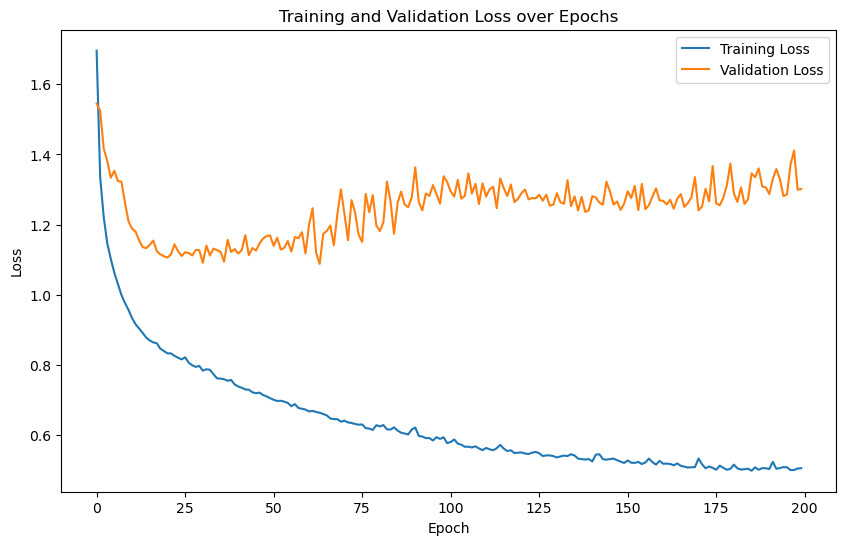

In [24]:
import matplotlib.pyplot as plt

 

def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_loss(history)

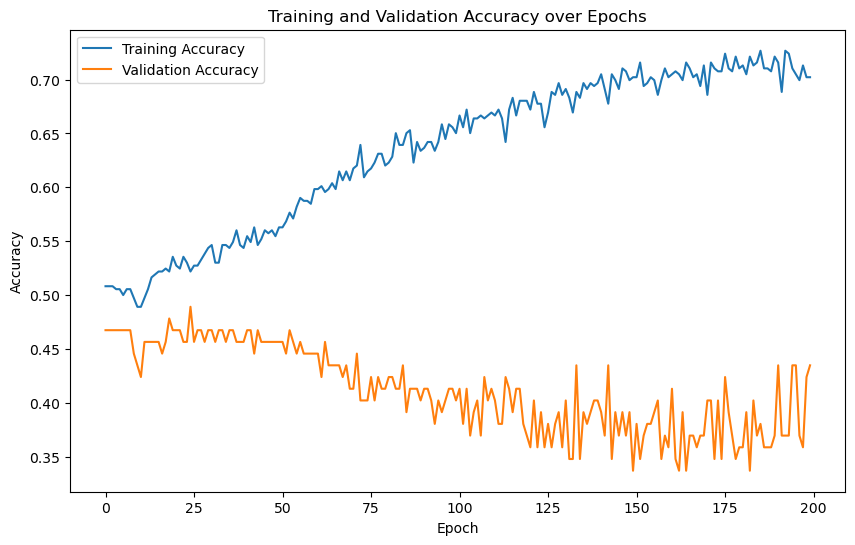

In [25]:
def plot_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

 

plot_accuracy(history)

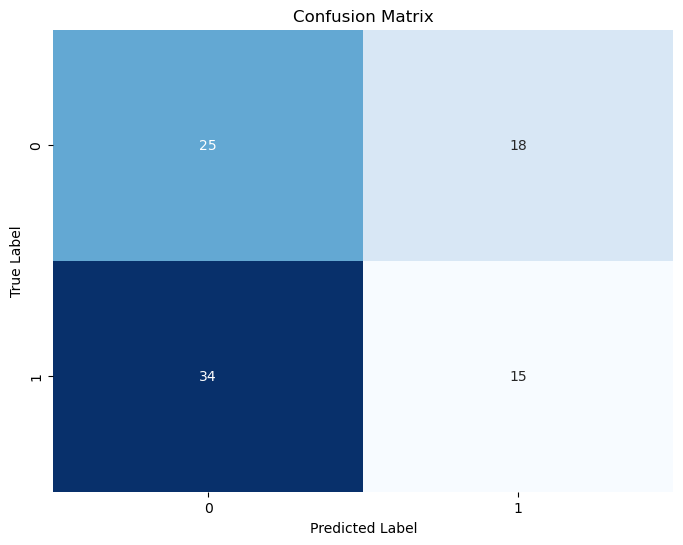

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(Y_val, binary_predictions)

 

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



L1 and L2 regularization are techniques used to prevent overfitting in neural networks. They work by adding a penalty to the loss function the network is trying to minimize.

L1 regularization (also known as Lasso regularization) adds a penalty proportional to the absolute value of the weights. This can lead to some weights being exactly zero, effectively removing certain features.

L2 regularization (also known as Ridge regularization) adds a penalty proportional to the squared value of the weights. This tends to make weights small, but not exactly zero.

WE use Keras to add L1 or L2 regularization to layers using the regularizers module.



In [21]:
from keras import regularizers
def create_modified_base_network(input_shape, l1_reg=0.01, l2_reg=0.01):
    model = Sequential()
    
    # Adding L2 regularization to Conv1D layers
    model.add(Conv1D(filters=256, kernel_size=50, strides=50, activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg), 
                     input_shape=input_shape))
    model.add(Conv1D(filters=128, kernel_size=10, strides=1, activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg)))

    model.add(Flatten())
    
    # Adding L1 regularization to the Dense layer
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(l1_reg)))
    
    return model



In [22]:
base_network = create_modified_base_network((13264, 1))
siamese_net = create_siamese_model(base_network, (13264, 1))


In [25]:
from keras.optimizers import Adam

# Compile the siamese network
optimizer = Adam(lr=0.0001)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train the siamese network
history = siamese_net.fit([X_1_train, X_2_train], Y_train,
                          validation_data=([X_1_val, X_2_val], Y_val),
                          epochs=200,
                          batch_size=32)


Epoch 1/200
12/12 [==============================] - 2s 159ms/step - loss: 0.7831 - accuracy: 0.6585 - val_loss: 1.3252 - val_accuracy: 0.4239
Epoch 2/200
12/12 [==============================] - 2s 148ms/step - loss: 0.7481 - accuracy: 0.6803 - val_loss: 1.2873 - val_accuracy: 0.4239
Epoch 3/200
12/12 [==============================] - 2s 147ms/step - loss: 0.7554 - accuracy: 0.6694 - val_loss: 1.2916 - val_accuracy: 0.4239
Epoch 4/200
12/12 [==============================] - 2s 147ms/step - loss: 0.7410 - accuracy: 0.6831 - val_loss: 1.3279 - val_accuracy: 0.4022
Epoch 5/200
12/12 [==============================] - 2s 148ms/step - loss: 0.7383 - accuracy: 0.6694 - val_loss: 1.2997 - val_accuracy: 0.4239
Epoch 6/200
12/12 [==============================] - 2s 147ms/step - loss: 0.7397 - accuracy: 0.6831 - val_loss: 1.3021 - val_accuracy: 0.4022
Epoch 7/200
12/12 [==============================] - 2s 148ms/step - loss: 0.7433 - accuracy: 0.6776 - val_loss: 1.3030 - val_accuracy: 0.4022

Epoch 58/200
12/12 [==============================] - 2s 151ms/step - loss: 0.7304 - accuracy: 0.6858 - val_loss: 1.3283 - val_accuracy: 0.4239
Epoch 59/200
12/12 [==============================] - 2s 151ms/step - loss: 0.7353 - accuracy: 0.6721 - val_loss: 1.3375 - val_accuracy: 0.4457
Epoch 60/200
12/12 [==============================] - 2s 147ms/step - loss: 0.7312 - accuracy: 0.6803 - val_loss: 1.3268 - val_accuracy: 0.4130
Epoch 61/200
12/12 [==============================] - 2s 148ms/step - loss: 0.7239 - accuracy: 0.6831 - val_loss: 1.3210 - val_accuracy: 0.4239
Epoch 62/200
12/12 [==============================] - 2s 148ms/step - loss: 0.7195 - accuracy: 0.6885 - val_loss: 1.3163 - val_accuracy: 0.3804
Epoch 63/200
12/12 [==============================] - 2s 152ms/step - loss: 0.7212 - accuracy: 0.6940 - val_loss: 1.3185 - val_accuracy: 0.4130
Epoch 64/200
12/12 [==============================] - 2s 148ms/step - loss: 0.7235 - accuracy: 0.6858 - val_loss: 1.3613 - val_accuracy:

Epoch 115/200
12/12 [==============================] - 2s 148ms/step - loss: 0.7093 - accuracy: 0.6885 - val_loss: 1.3277 - val_accuracy: 0.4239
Epoch 116/200
12/12 [==============================] - 2s 150ms/step - loss: 0.7087 - accuracy: 0.6940 - val_loss: 1.3209 - val_accuracy: 0.4130
Epoch 117/200
12/12 [==============================] - 2s 149ms/step - loss: 0.7090 - accuracy: 0.7022 - val_loss: 1.3133 - val_accuracy: 0.4130
Epoch 118/200
12/12 [==============================] - 2s 150ms/step - loss: 0.7062 - accuracy: 0.6858 - val_loss: 1.3365 - val_accuracy: 0.4348
Epoch 119/200
12/12 [==============================] - 2s 150ms/step - loss: 0.7149 - accuracy: 0.6885 - val_loss: 1.3200 - val_accuracy: 0.4130
Epoch 120/200
12/12 [==============================] - 2s 152ms/step - loss: 0.7108 - accuracy: 0.6995 - val_loss: 1.3147 - val_accuracy: 0.4022
Epoch 121/200
12/12 [==============================] - 2s 150ms/step - loss: 0.7075 - accuracy: 0.7077 - val_loss: 1.3204 - val_ac

In [26]:
predictions = siamese_net.predict([X_1_val, X_2_val])

3/3 [==============================] - 0s 36ms/step


In [27]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Convert the continuous predictions to binary
binary_predictions = np.round(predictions).flatten()

# Compute the metrics
f1 = f1_score(Y_val, binary_predictions)
precision = precision_score(Y_val, binary_predictions)
recall = recall_score(Y_val, binary_predictions)
auc = roc_auc_score(Y_val, predictions)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc:.4f}")

F1 Score: 0.2192
Precision: 0.3333
Recall: 0.1633
AUC-ROC: 0.4438


try dropout variations

In [28]:
from keras.layers import Dropout

def create_modified_base_network(input_shape, dropout_rate=0.0):
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=50, strides=50, activation='relu', padding='same', input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(filters=128, kernel_size=10, strides=1, activation='relu', padding='same'))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [29]:
dropout_rates = [0.1, 0.3, 0.5]
histories = []

for rate in dropout_rates:
    print(f"Training with dropout rate: {rate}")
    
    # Instantiate the models with dropout
    base_network = create_modified_base_network((13264, 1), dropout_rate=rate)
    siamese_net = create_siamese_model(base_network, (13264, 1))
    
    # Load the pre-trained weights
    siamese_net.load_weights('C:/Users/psxyy18/Downloads/CancerSiamese-master/Saved_weights_and_model/TCGA/TCGA_trans_19.h5', by_name=True)
    
    # Freeze the first convolutional layer
    base_network.layers[0].trainable = False

    # Compile the model
    optimizer = Adam(lr=0.0001)
    siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    # Train the model
    history = siamese_net.fit([X_1_train, X_2_train], Y_train,
                              validation_data=([X_1_val, X_2_val], Y_val),
                              epochs=200,
                              batch_size=32)
    
    histories.append(history)


Training with dropout rate: 0.1
Epoch 1/200


C:\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - 2s 150ms/step - loss: 1.6427 - accuracy: 0.5082 - val_loss: 1.8258 - val_accuracy: 0.4674
Epoch 2/200
12/12 [==============================] - 2s 135ms/step - loss: 1.3636 - accuracy: 0.5082 - val_loss: 1.6964 - val_accuracy: 0.4674
Epoch 3/200
12/12 [==============================] - 2s 136ms/step - loss: 1.3590 - accuracy: 0.5082 - val_loss: 1.6567 - val_accuracy: 0.4674
Epoch 4/200
12/12 [==============================] - 2s 136ms/step - loss: 1.3723 - accuracy: 0.5082 - val_loss: 1.7834 - val_accuracy: 0.4674
Epoch 5/200
12/12 [==============================] - 2s 138ms/step - loss: 1.4300 - accuracy: 0.5082 - val_loss: 1.7195 - val_accuracy: 0.4674
Epoch 6/200
12/12 [==============================] - 2s 141ms/step - loss: 1.3268 - accuracy: 0.5082 - val_loss: 1.7395 - val_accuracy: 0.4674
Epoch 7/200
12/12 [==============================] - 2s 136ms/step - loss: 1.5574 - accuracy: 0.5082 - val_loss: 1.8487 - val_accuracy: 0.4674
Epoch 8/200

12/12 [==============================] - 2s 134ms/step - loss: 0.9482 - accuracy: 0.5410 - val_loss: 1.2597 - val_accuracy: 0.4565
Epoch 59/200
12/12 [==============================] - 2s 134ms/step - loss: 0.9287 - accuracy: 0.5464 - val_loss: 1.2905 - val_accuracy: 0.4783
Epoch 60/200
12/12 [==============================] - 2s 136ms/step - loss: 0.9751 - accuracy: 0.5164 - val_loss: 1.2850 - val_accuracy: 0.4783
Epoch 61/200
12/12 [==============================] - 2s 135ms/step - loss: 1.0419 - accuracy: 0.5164 - val_loss: 1.4343 - val_accuracy: 0.4348
Epoch 62/200
12/12 [==============================] - 2s 136ms/step - loss: 1.1297 - accuracy: 0.5301 - val_loss: 1.3202 - val_accuracy: 0.4348
Epoch 63/200
12/12 [==============================] - 2s 137ms/step - loss: 0.9521 - accuracy: 0.5519 - val_loss: 1.3269 - val_accuracy: 0.4891
Epoch 64/200
12/12 [==============================] - 2s 137ms/step - loss: 0.9825 - accuracy: 0.5355 - val_loss: 1.2951 - val_accuracy: 0.4891
Epoch

Epoch 115/200
12/12 [==============================] - 2s 137ms/step - loss: 0.9495 - accuracy: 0.5301 - val_loss: 1.2567 - val_accuracy: 0.4674
Epoch 116/200
12/12 [==============================] - 2s 135ms/step - loss: 1.0351 - accuracy: 0.5328 - val_loss: 1.3560 - val_accuracy: 0.4348
Epoch 117/200
12/12 [==============================] - 2s 134ms/step - loss: 1.0017 - accuracy: 0.5437 - val_loss: 1.2082 - val_accuracy: 0.4891
Epoch 118/200
12/12 [==============================] - 2s 135ms/step - loss: 0.9144 - accuracy: 0.5383 - val_loss: 1.2004 - val_accuracy: 0.4565
Epoch 119/200
12/12 [==============================] - 2s 133ms/step - loss: 0.9303 - accuracy: 0.5437 - val_loss: 1.2671 - val_accuracy: 0.4891
Epoch 120/200
12/12 [==============================] - 2s 134ms/step - loss: 0.9054 - accuracy: 0.5574 - val_loss: 1.2375 - val_accuracy: 0.5000
Epoch 121/200
12/12 [==============================] - 2s 135ms/step - loss: 0.9647 - accuracy: 0.5628 - val_loss: 1.2021 - val_ac

12/12 [==============================] - 2s 138ms/step - loss: 1.2099 - accuracy: 0.5109 - val_loss: 1.7047 - val_accuracy: 0.4674
Epoch 28/200
12/12 [==============================] - 2s 136ms/step - loss: 1.2068 - accuracy: 0.5109 - val_loss: 1.6509 - val_accuracy: 0.4674
Epoch 29/200
12/12 [==============================] - 2s 134ms/step - loss: 1.2277 - accuracy: 0.5109 - val_loss: 1.7062 - val_accuracy: 0.4674
Epoch 30/200
12/12 [==============================] - 2s 138ms/step - loss: 1.2495 - accuracy: 0.5137 - val_loss: 1.5507 - val_accuracy: 0.4674
Epoch 31/200
12/12 [==============================] - 2s 134ms/step - loss: 1.5905 - accuracy: 0.5055 - val_loss: 2.3492 - val_accuracy: 0.4674
Epoch 32/200
12/12 [==============================] - 2s 138ms/step - loss: 2.0051 - accuracy: 0.5082 - val_loss: 2.2380 - val_accuracy: 0.4674
Epoch 33/200
12/12 [==============================] - 2s 134ms/step - loss: 1.7533 - accuracy: 0.5082 - val_loss: 1.8534 - val_accuracy: 0.4674
Epoch

Epoch 84/200
12/12 [==============================] - 2s 135ms/step - loss: 1.0201 - accuracy: 0.5246 - val_loss: 1.1739 - val_accuracy: 0.4674
Epoch 85/200
12/12 [==============================] - 2s 135ms/step - loss: 1.0083 - accuracy: 0.5137 - val_loss: 1.1480 - val_accuracy: 0.4783
Epoch 86/200
12/12 [==============================] - 2s 136ms/step - loss: 1.0021 - accuracy: 0.5137 - val_loss: 1.1351 - val_accuracy: 0.4783
Epoch 87/200
12/12 [==============================] - 2s 134ms/step - loss: 0.9787 - accuracy: 0.5246 - val_loss: 1.1296 - val_accuracy: 0.4783
Epoch 88/200
12/12 [==============================] - 2s 135ms/step - loss: 0.9495 - accuracy: 0.5328 - val_loss: 1.1477 - val_accuracy: 0.4565
Epoch 89/200
12/12 [==============================] - 2s 135ms/step - loss: 1.0505 - accuracy: 0.5519 - val_loss: 1.1666 - val_accuracy: 0.4565
Epoch 90/200
12/12 [==============================] - 2s 133ms/step - loss: 0.9944 - accuracy: 0.5191 - val_loss: 1.1690 - val_accuracy:

12/12 [==============================] - 2s 136ms/step - loss: 0.9972 - accuracy: 0.5137 - val_loss: 1.3200 - val_accuracy: 0.4783
Epoch 197/200
12/12 [==============================] - 2s 134ms/step - loss: 1.0834 - accuracy: 0.5109 - val_loss: 1.8134 - val_accuracy: 0.4674
Epoch 198/200
12/12 [==============================] - 2s 134ms/step - loss: 1.2312 - accuracy: 0.5000 - val_loss: 1.7768 - val_accuracy: 0.4674
Epoch 199/200
12/12 [==============================] - 2s 133ms/step - loss: 1.0753 - accuracy: 0.5027 - val_loss: 1.6721 - val_accuracy: 0.4674
Epoch 200/200
12/12 [==============================] - 2s 137ms/step - loss: 1.3359 - accuracy: 0.5000 - val_loss: 2.6869 - val_accuracy: 0.4674
Training with dropout rate: 0.5
Epoch 1/200
12/12 [==============================] - 2s 146ms/step - loss: 1.1829 - accuracy: 0.5109 - val_loss: 2.0772 - val_accuracy: 0.4674
Epoch 2/200
12/12 [==============================] - 2s 135ms/step - loss: 1.2423 - accuracy: 0.5027 - val_loss: 1

Epoch 53/200
12/12 [==============================] - 2s 133ms/step - loss: 1.1260 - accuracy: 0.5027 - val_loss: 1.6204 - val_accuracy: 0.4674
Epoch 54/200
12/12 [==============================] - 2s 135ms/step - loss: 1.1092 - accuracy: 0.4809 - val_loss: 1.7159 - val_accuracy: 0.4674
Epoch 55/200
12/12 [==============================] - 2s 136ms/step - loss: 1.0937 - accuracy: 0.4918 - val_loss: 1.8132 - val_accuracy: 0.4674
Epoch 56/200
12/12 [==============================] - 2s 134ms/step - loss: 1.0897 - accuracy: 0.5164 - val_loss: 1.8495 - val_accuracy: 0.4674
Epoch 57/200
12/12 [==============================] - 2s 137ms/step - loss: 1.0761 - accuracy: 0.5000 - val_loss: 1.8808 - val_accuracy: 0.4674
Epoch 58/200
12/12 [==============================] - 2s 134ms/step - loss: 1.1298 - accuracy: 0.5137 - val_loss: 1.7543 - val_accuracy: 0.4674
Epoch 59/200
12/12 [==============================] - 2s 134ms/step - loss: 1.0317 - accuracy: 0.5137 - val_loss: 1.8854 - val_accuracy:

Epoch 110/200
12/12 [==============================] - 2s 149ms/step - loss: 1.2466 - accuracy: 0.4891 - val_loss: 2.4071 - val_accuracy: 0.4674
Epoch 111/200
12/12 [==============================] - 2s 147ms/step - loss: 2.4078 - accuracy: 0.5082 - val_loss: 2.9536 - val_accuracy: 0.4674
Epoch 112/200
12/12 [==============================] - 2s 141ms/step - loss: 2.4299 - accuracy: 0.5082 - val_loss: 2.7117 - val_accuracy: 0.4674
Epoch 113/200
12/12 [==============================] - 2s 148ms/step - loss: 2.0700 - accuracy: 0.5082 - val_loss: 2.2396 - val_accuracy: 0.4674
Epoch 114/200
12/12 [==============================] - 2s 166ms/step - loss: 1.5242 - accuracy: 0.5109 - val_loss: 1.8592 - val_accuracy: 0.4674
Epoch 115/200
12/12 [==============================] - 2s 161ms/step - loss: 1.2281 - accuracy: 0.5246 - val_loss: 1.7594 - val_accuracy: 0.4674
Epoch 116/200
12/12 [==============================] - 2s 163ms/step - loss: 1.0641 - accuracy: 0.5027 - val_loss: 1.9742 - val_ac

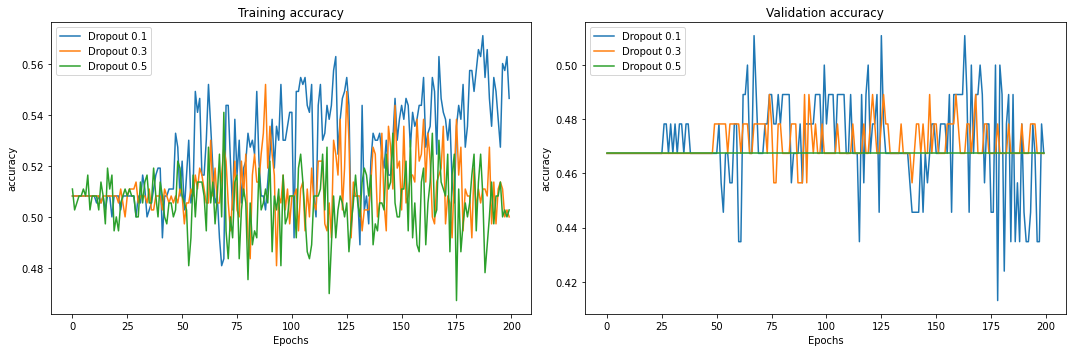

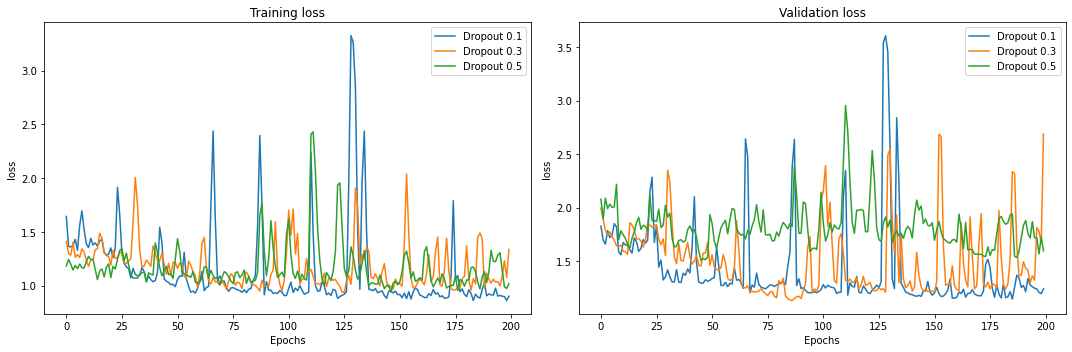

In [30]:
import matplotlib.pyplot as plt

def plot_histories(histories, dropout_rates, metric='accuracy'):
    """
    Plot training and validation metrics for different dropout rates.
    
    Arguments:
    - histories: List of history objects.
    - dropout_rates: List of dropout rates.
    - metric: Metric to be plotted. (default is 'accuracy')
    """
    plt.figure(figsize=(15, 5))
    
    # Subplot 1 for training metric
    plt.subplot(1, 2, 1)
    for history, rate in zip(histories, dropout_rates):
        plt.plot(history.history[metric], label=f"Dropout {rate}")
    plt.title(f'Training {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    
    # Subplot 2 for validation metric
    plt.subplot(1, 2, 2)
    for history, rate in zip(histories, dropout_rates):
        plt.plot(history.history[f'val_{metric}'], label=f"Dropout {rate}")
    plt.title(f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting accuracy
plot_histories(histories, dropout_rates, 'accuracy')

# Plotting loss
plot_histories(histories, dropout_rates, 'loss')


In [31]:
for rate, history in zip(dropout_rates, histories):
    print(f"Dropout Rate: {rate}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print("--------------------------------------------------------")



Dropout Rate: 0.1
Final Training Accuracy: 0.5464
Final Validation Accuracy: 0.4674
Final Training Loss: 0.8996
Final Validation Loss: 1.2393
--------------------------------------------------------
Dropout Rate: 0.3
Final Training Accuracy: 0.5000
Final Validation Accuracy: 0.4674
Final Training Loss: 1.3359
Final Validation Loss: 2.6869
--------------------------------------------------------
Dropout Rate: 0.5
Final Training Accuracy: 0.5027
Final Validation Accuracy: 0.4674
Final Training Loss: 1.0184
Final Validation Loss: 1.5937
--------------------------------------------------------


try data augmentation

In [47]:
import numpy as np

def jitter(data, sigma=0.05):
    noise = np.random.normal(loc=0, scale=sigma, size=data.shape)
    return data + noise

def scaling(data, sigma=0.1):
    scaling_factor = np.random.normal(loc=1.0, scale=sigma, size=data.shape)
    return data * scaling_factor

def permutation(data, fraction=0.01):
    n_swap = int(data.shape[0] * fraction)
    idx = np.random.permutation(data.shape[0])[:n_swap]
    swapped_data = data.copy()
    swapped_data[idx] = data[np.random.permutation(idx)]
    return swapped_data

def mixup(data, alpha=0.2):
    n = data.shape[0]
    weight = np.random.beta(alpha, alpha, n)
    index = np.random.permutation(n)
    mixed_data = weight * data + (1 - weight) * data[index]
    return mixed_data

def augment_data(data):
    # Apply each augmentation with a 25% chance
    if np.random.rand() < 0.25:
        data = jitter(data)
    if np.random.rand() < 0.25:
        data = scaling(data)
    if np.random.rand() < 0.25:
        data = permutation(data)
    if np.random.rand() < 0.25:
        data = mixup(data)
    return data


In [70]:

!pip install tqdm
from tqdm import tqdm
import numpy as np

def augment_samples(data, num_augmentations=2):
    augmented_data = [data]  # Include the original data

    for _ in range(num_augmentations):
        augmented = np.copy(data)
        
        # Random shifts (-0.05 to 0.05)
        shift = (-0.05 + np.random.rand(*data.shape)) * 0.1
        augmented += shift

        augmented_data.append(augmented)

    return np.vstack(augmented_data)

    
    return np.vstack(augmented_data)
def augment_data_pairwise(X_1, X_2, Y, num_augmentations=2):
    X_1_augmented_list, X_2_augmented_list, Y_augmented_list = [], [], []
    
    for i in range(len(X_1)):
        # Augment X_1
        augmented_X_1 = augment_samples(np.expand_dims(X_1[i], axis=0), num_augmentations)
        
        # Augment X_2
        augmented_X_2 = augment_samples(np.expand_dims(X_2[i], axis=0), num_augmentations)
        
        # Replicate label
        replicated_Y = np.array([Y[i]] * (num_augmentations + 1))
        
        X_1_augmented_list.append(augmented_X_1)
        X_2_augmented_list.append(augmented_X_2)
        Y_augmented_list.append(replicated_Y)
    
    return np.vstack(X_1_augmented_list), np.vstack(X_2_augmented_list), np.hstack(Y_augmented_list)

X_1_train_augmented, X_2_train_augmented, Y_train_augmented = augment_data_pairwise(X_1_train, X_2_train, Y_train)







In [71]:
history = siamese_net.fit(
    [X_1_train_augmented, X_2_train_augmented], Y_train_augmented,
    validation_data=([X_1_val, X_2_val], Y_val),
    epochs=200,
    batch_size=32,
    verbose=2
)


Epoch 1/200
35/35 - 4s - loss: 1.2625 - accuracy: 0.5091 - val_loss: 1.2664 - val_accuracy: 0.4783 - 4s/epoch - 117ms/step
Epoch 2/200
35/35 - 3s - loss: 0.9918 - accuracy: 0.5173 - val_loss: 1.1931 - val_accuracy: 0.4891 - 3s/epoch - 97ms/step
Epoch 3/200
35/35 - 3s - loss: 0.8894 - accuracy: 0.5273 - val_loss: 1.1506 - val_accuracy: 0.4674 - 3s/epoch - 96ms/step
Epoch 4/200
35/35 - 3s - loss: 0.8695 - accuracy: 0.5401 - val_loss: 1.1725 - val_accuracy: 0.4674 - 3s/epoch - 96ms/step
Epoch 5/200
35/35 - 3s - loss: 0.8226 - accuracy: 0.5364 - val_loss: 1.1672 - val_accuracy: 0.4565 - 3s/epoch - 97ms/step
Epoch 6/200
35/35 - 3s - loss: 0.8081 - accuracy: 0.5392 - val_loss: 1.1436 - val_accuracy: 0.4565 - 3s/epoch - 96ms/step
Epoch 7/200
35/35 - 3s - loss: 0.7902 - accuracy: 0.5346 - val_loss: 1.1506 - val_accuracy: 0.4565 - 3s/epoch - 97ms/step
Epoch 8/200
35/35 - 3s - loss: 0.7804 - accuracy: 0.5492 - val_loss: 1.1559 - val_accuracy: 0.4674 - 3s/epoch - 95ms/step
Epoch 9/200
35/35 - 3s 

Epoch 68/200
35/35 - 3s - loss: 0.5635 - accuracy: 0.6466 - val_loss: 1.1208 - val_accuracy: 0.4130 - 3s/epoch - 95ms/step
Epoch 69/200
35/35 - 3s - loss: 0.5620 - accuracy: 0.6485 - val_loss: 1.1267 - val_accuracy: 0.4239 - 3s/epoch - 97ms/step
Epoch 70/200
35/35 - 3s - loss: 0.5622 - accuracy: 0.6330 - val_loss: 1.1212 - val_accuracy: 0.4022 - 3s/epoch - 96ms/step
Epoch 71/200
35/35 - 3s - loss: 0.5661 - accuracy: 0.6384 - val_loss: 1.1619 - val_accuracy: 0.4239 - 3s/epoch - 98ms/step
Epoch 72/200
35/35 - 3s - loss: 0.5620 - accuracy: 0.6448 - val_loss: 1.1617 - val_accuracy: 0.3913 - 3s/epoch - 96ms/step
Epoch 73/200
35/35 - 3s - loss: 0.5631 - accuracy: 0.6403 - val_loss: 1.1504 - val_accuracy: 0.4239 - 3s/epoch - 97ms/step
Epoch 74/200
35/35 - 3s - loss: 0.5621 - accuracy: 0.6457 - val_loss: 1.1384 - val_accuracy: 0.4348 - 3s/epoch - 96ms/step
Epoch 75/200
35/35 - 3s - loss: 0.5637 - accuracy: 0.6384 - val_loss: 1.1709 - val_accuracy: 0.4239 - 3s/epoch - 95ms/step
Epoch 76/200
35/

Epoch 135/200
35/35 - 3s - loss: 0.5486 - accuracy: 0.6548 - val_loss: 1.2628 - val_accuracy: 0.4783 - 3s/epoch - 95ms/step
Epoch 136/200
35/35 - 3s - loss: 0.5665 - accuracy: 0.6375 - val_loss: 1.1614 - val_accuracy: 0.4348 - 3s/epoch - 95ms/step
Epoch 137/200
35/35 - 3s - loss: 0.5403 - accuracy: 0.6694 - val_loss: 1.2169 - val_accuracy: 0.4565 - 3s/epoch - 95ms/step
Epoch 138/200
35/35 - 3s - loss: 0.5754 - accuracy: 0.6448 - val_loss: 1.1923 - val_accuracy: 0.4674 - 3s/epoch - 95ms/step
Epoch 139/200
35/35 - 3s - loss: 0.5540 - accuracy: 0.6530 - val_loss: 1.1801 - val_accuracy: 0.3804 - 3s/epoch - 96ms/step
Epoch 140/200
35/35 - 3s - loss: 0.5452 - accuracy: 0.6603 - val_loss: 1.1387 - val_accuracy: 0.4457 - 3s/epoch - 96ms/step
Epoch 141/200
35/35 - 3s - loss: 0.5425 - accuracy: 0.6566 - val_loss: 1.2345 - val_accuracy: 0.4565 - 3s/epoch - 96ms/step
Epoch 142/200
35/35 - 3s - loss: 0.5418 - accuracy: 0.6603 - val_loss: 1.2135 - val_accuracy: 0.3913 - 3s/epoch - 97ms/step
Epoch 14

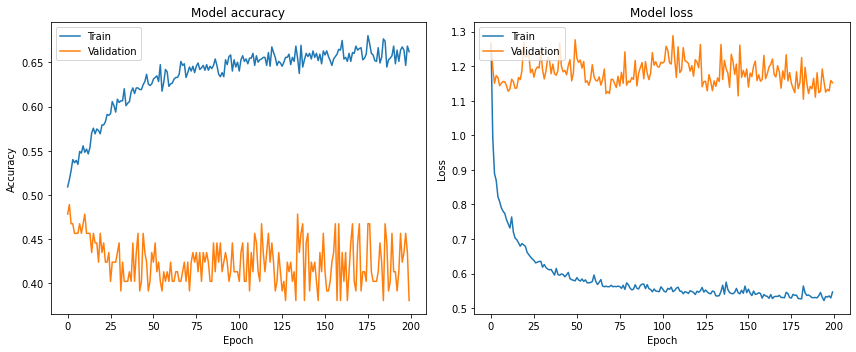

In [72]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [73]:
# Extract metrics from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the final epoch's metrics
final_train_accuracy = train_accuracy[-1]
final_val_accuracy = val_accuracy[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

# Print the metrics
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.6621
Final Validation Accuracy: 0.3804
Final Training Loss: 0.5468
Final Validation Loss: 1.1522


Refining the Model Architecture

In [89]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from sklearn.model_selection import train_test_split

import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from sklearn.model_selection import train_test_split


def create_model_variation(layers, neurons):
    input_1 = Input(shape=(X_1.shape[1],))
    input_2 = Input(shape=(X_2.shape[1],))
    merged = concatenate([input_1, input_2])
    
    x = Dense(neurons[0], activation='relu')(merged)
    for i in range(1, layers):
        x = Dense(neurons[i], activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[input_1, input_2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Splitting the dataset
(X_1_train, X_1_temp,
 X_2_train, X_2_temp,
 Y_train, Y_temp) = train_test_split(X_1, X_2, Y, test_size=0.3, random_state=42)

(X_1_val, X_1_test,
 X_2_val, X_2_test,
 Y_val, Y_test) = train_test_split(X_1_temp, X_2_temp, Y_temp, test_size=0.5, random_state=42)

# Different configurations
configurations = [
    (2, [64, 64]),     # 2 layers, 64 neurons each
    (3, [64, 64, 64]), # 3 layers, 64 neurons each
    (4, [64, 64, 64,64]), # 4 layers, 64 neurons each
    (5, [64, 64, 64,64,64]), # 4 layers, 64 neurons each
    (6, [64, 64, 64,64,64,64]), # 4 layers, 64 neurons each
    (7, [64, 64, 64,64,64,64,64]), # 4 layers, 64 neurons each
    (8, [64, 64, 64,64,64,64,64,64]), # 4 layers, 64 neurons each
    (9, [64, 64, 64,64,64,64,64,64,64]), # 4 layers, 64 neurons each
    (10, [64, 64, 64,64,64,64,64,64,64,64]), # 4 layers, 64 neurons each
]



num_runs = 5
results = {}

for config in configurations:
    layers, neurons = config
    config_key = (layers, tuple(neurons))
    val_accuracies = []
    test_accuracies = []
    
    for _ in range(num_runs):
        model = create_model_variation(layers, neurons)
        model.fit([X_1_train, X_2_train], Y_train, epochs=10, batch_size=32, validation_data=([X_1_val, X_2_val], Y_val), verbose=0)
        
        val_loss, val_accuracy = model.evaluate([X_1_val, X_2_val], Y_val, verbose=0)
        test_loss, test_accuracy = model.evaluate([X_1_test, X_2_test], Y_test, verbose=0)
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
    
    avg_val_accuracy = np.mean(val_accuracies)
    avg_test_accuracy = np.mean(test_accuracies)
    
    results[config_key] = (avg_val_accuracy, avg_test_accuracy)
    print(f"Configuration {config_key} - Average validation accuracy over {num_runs} runs: {avg_val_accuracy:.4f} - Test accuracy: {avg_test_accuracy:.4f}")

best_config = max(results, key=lambda k: results[k][0])
print(f"Best configuration: {best_config} with average validation accuracy over {num_runs} runs: {results[best_config][0]:.4f} and test accuracy: {results[best_config][1]:.4f}")







Configuration (2, (64, 64)) - Average validation accuracy over 5 runs: 0.4696 - Test accuracy: 0.4841
Configuration (3, (64, 64, 64)) - Average validation accuracy over 5 runs: 0.4783 - Test accuracy: 0.5101
Configuration (4, (64, 64, 64, 64)) - Average validation accuracy over 5 runs: 0.4899 - Test accuracy: 0.5072
Configuration (5, (64, 64, 64, 64, 64)) - Average validation accuracy over 5 runs: 0.4319 - Test accuracy: 0.4957
Configuration (6, (64, 64, 64, 64, 64, 64)) - Average validation accuracy over 5 runs: 0.4870 - Test accuracy: 0.5043
Configuration (7, (64, 64, 64, 64, 64, 64, 64)) - Average validation accuracy over 5 runs: 0.5188 - Test accuracy: 0.5362
Configuration (8, (64, 64, 64, 64, 64, 64, 64, 64)) - Average validation accuracy over 5 runs: 0.4725 - Test accuracy: 0.5101
Configuration (9, (64, 64, 64, 64, 64, 64, 64, 64, 64)) - Average validation accuracy over 5 runs: 0.4870 - Test accuracy: 0.5014
Configuration (10, (64, 64, 64, 64, 64, 64, 64, 64, 64, 64)) - Average v

early stopping

In [91]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


def create_modified_base_network(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=50, strides=50, activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv1D(filters=128, kernel_size=10, strides=1, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model
from keras.layers import Input
from keras.models import Model

def create_siamese_model(base_network, input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
    
    siamese_net = Model([input_a, input_b], distance)
    return siamese_net
from keras.layers import Lambda
import keras.backend as K


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

 

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

    # Instantiate the models
base_network = create_modified_base_network((13264, 1))
siamese_net = create_siamese_model(base_network, (13264, 1))

# Load the pre-trained weights
siamese_net.load_weights('C:/Users/psxyy18/Downloads/CancerSiamese-master/Saved_weights_and_model/TCGA/TCGA_trans_19.h5', by_name=True) # Freeze the first convolutional layer
base_network.layers[0].trainable = False

# Check which layers are frozen
for layer in base_network.layers:
    print(f"{layer.name}: {layer.trainable}") 
from keras.optimizers import Adam
optimizer = Adam(lr=0.0001)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = siamese_net.fit([X_1_train, X_2_train], Y_train,
                          validation_data=([X_1_val, X_2_val], Y_val),
                          epochs=200,
                          batch_size=32,
                          callbacks=[early_stop])


conv1d_22: False
conv1d_23: True
flatten_15: True
dense_908: True
Epoch 1/200


C:\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 121ms/step - loss: 1.6176 - accuracy: 0.5156 - val_loss: 1.8232 - val_accuracy: 0.4348
Epoch 2/200
10/10 [==============================] - 1s 108ms/step - loss: 1.5914 - accuracy: 0.5156 - val_loss: 1.7843 - val_accuracy: 0.4348
Epoch 3/200
10/10 [==============================] - 1s 107ms/step - loss: 1.4710 - accuracy: 0.5156 - val_loss: 1.5733 - val_accuracy: 0.4348
Epoch 4/200
10/10 [==============================] - 1s 106ms/step - loss: 1.2891 - accuracy: 0.5156 - val_loss: 1.4833 - val_accuracy: 0.4348
Epoch 5/200
10/10 [==============================] - 1s 106ms/step - loss: 1.1787 - accuracy: 0.5156 - val_loss: 1.3755 - val_accuracy: 0.4348
Epoch 6/200
10/10 [==============================] - 1s 106ms/step - loss: 1.0961 - accuracy: 0.5125 - val_loss: 1.2773 - val_accuracy: 0.4493
Epoch 7/200
10/10 [==============================] - 1s 107ms/step - loss: 1.0534 - accuracy: 0.5125 - val_loss: 1.2382 - val_accuracy: 0.4493
Epoch 8/200

10/10 [==============================] - 1s 107ms/step - loss: 0.6932 - accuracy: 0.5844 - val_loss: 0.9961 - val_accuracy: 0.4058
Epoch 59/200
10/10 [==============================] - 1s 107ms/step - loss: 0.6845 - accuracy: 0.5938 - val_loss: 0.9854 - val_accuracy: 0.4203
Epoch 60/200
10/10 [==============================] - 1s 108ms/step - loss: 0.6832 - accuracy: 0.5969 - val_loss: 0.9954 - val_accuracy: 0.4203
Epoch 61/200
10/10 [==============================] - 1s 107ms/step - loss: 0.6773 - accuracy: 0.5906 - val_loss: 0.9886 - val_accuracy: 0.4203
Epoch 62/200
10/10 [==============================] - 1s 108ms/step - loss: 0.6815 - accuracy: 0.5906 - val_loss: 0.9955 - val_accuracy: 0.4203
Epoch 63/200
10/10 [==============================] - 1s 108ms/step - loss: 0.6731 - accuracy: 0.5813 - val_loss: 1.0019 - val_accuracy: 0.4203
Epoch 64/200
10/10 [==============================] - 1s 108ms/step - loss: 0.6721 - accuracy: 0.5938 - val_loss: 1.0013 - val_accuracy: 0.3768
Epoch

In [99]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Conv1D, Dense, Flatten, Lambda
from keras.optimizers import Adam
import keras.backend as K

# Load the pre-trained weights into the Siamese model
siamese_net.load_weights('C:/Users/psxyy18/Downloads/CancerSiamese-master/Saved_weights_and_model/TCGA/TCGA_trans_19.h5', by_name=True)

# Define an optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Function to freeze the initial layers
def freeze_initial_layers(model, num_layers_to_freeze):
    for layer in model.layers[:num_layers_to_freeze]:
        layer.trainable = False
    for layer in model.layers[num_layers_to_freeze:]:
        layer.trainable = True

# Experiment with different numbers of frozen layers
frozen_layers_config = [1, 2, 3]  # Adjust this list as needed

results = {}

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for num in frozen_layers_config:
    # Freeze the specified number of layers
    freeze_initial_layers(base_network, num)
    
    # Train the model
    history = siamese_net.fit([X_1_train, X_2_train], Y_train,
                              validation_data=([X_1_val, X_2_val], Y_val),
                              epochs=200,  # This can be adjusted based on when convergence is observed
                              batch_size=32,
                              verbose=1,
                              callbacks=[early_stopping])
    
    # Store the final validation accuracy for this configuration
    final_val_acc = history.history['val_accuracy'][-1]  # Get the last validation accuracy
    results[num] = final_val_acc

# Print the results
for num_layers, val_acc in results.items():
    print(f"Number of frozen layers: {num_layers} - Validation accuracy: {val_acc:.4f}")


Epoch 1/200
10/10 [==============================] - 1s 64ms/step - loss: 0.4937 - accuracy: 0.6938 - val_loss: 1.0931 - val_accuracy: 0.4203
Epoch 2/200
10/10 [==============================] - 0s 50ms/step - loss: 0.4855 - accuracy: 0.6938 - val_loss: 1.1201 - val_accuracy: 0.4493
Epoch 3/200
10/10 [==============================] - 1s 50ms/step - loss: 0.4807 - accuracy: 0.7094 - val_loss: 1.0920 - val_accuracy: 0.4348
Epoch 4/200
10/10 [==============================] - 1s 52ms/step - loss: 0.4830 - accuracy: 0.6938 - val_loss: 1.0936 - val_accuracy: 0.4203
Epoch 5/200
10/10 [==============================] - 0s 49ms/step - loss: 0.4822 - accuracy: 0.6906 - val_loss: 1.1042 - val_accuracy: 0.4493
Epoch 6/200
10/10 [==============================] - 0s 51ms/step - loss: 0.4808 - accuracy: 0.7000 - val_loss: 1.1032 - val_accuracy: 0.4638
Epoch 7/200
10/10 [==============================] - 0s 50ms/step - loss: 0.4856 - accuracy: 0.7219 - val_loss: 1.0926 - val_accuracy: 0.4493
Epoch 